# Hate Crime and Facebok

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import datetime

## Basic Preprocessing of Hate Crime Data

In [2]:
hate_crime = pd.read_csv('/home3/r05322021/Desktop/FB Data/hate_crime_data/hate_crime.csv')
hate_crime.date = pd.to_datetime(hate_crime.date)
hate_crime = hate_crime[(hate_crime.date.dt.date >= datetime.date(2015,5,3)) & (hate_crime.date.dt.date < datetime.date(2016,11,27))]
hate_crime['Week'] = hate_crime['date'].apply(lambda x: datetime.date(2015,5,3) + datetime.timedelta(days=np.floor(((x.date() - datetime.date(2015,5,3)).days)/7)*7))
hate_crime['week'] = hate_crime['date'].apply(lambda x: np.floor(((x.date() - datetime.date(2015,5,3)).days)/7) + 1)
hate_crime

,agency,year,city,population_group,country_division,country_region,agency_indicator,core_city,population,state,...,offense_type,number_of_group_victims,location,motivation,victim_type,week,month_year,month,state_name,Week
1,AK0010100,2015,ANCHORAGE,1C,9,4,1,Y,301239,50,...,13C,1,9,12,I,29.0,2015-11,11,Alaska,2015-11-15
2,AK0010100,2015,ANCHORAGE,1C,9,4,1,Y,301239,50,...,13C,10,20,12,I,13.0,2015-07,7,Alaska,2015-07-26
3,AK0010100,2015,ANCHORAGE,1C,9,4,1,Y,301239,50,...,200,1,5,43,NaN,6.0,2015-06,6,Alaska,2015-06-07
4,AK0010100,2015,ANCHORAGE,1C,9,4,1,Y,301239,50,...,13A,1,13,12,I,14.0,2015-08,8,Alaska,2015-08-02
5,AK0010100,2016,ANCHORAGE,1C,9,4,1,Y,299097,50,...,13B,1,53,12,I,41.0,2016-02,2,Alaska,2016-02-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,WY0030100,2015,GILLETTE,4,8,4,1,N,32502,49,...,13B,1,13,15,I,18.0,2015-09,9,Wyoming,2015-08-30
19141,WY0030100,2015,GILLETTE,4,8,4,1,N,32502,49,...,13B,1,54,12,I,23.0,2015-10,10,Wyoming,2015-10-04
19142,WY0030100,2016,GILLETTE,4,8,4,1,N,33218,49,...,13B,2,53,32,I,55.0,2016-05,5,Wyoming,2016-05-15
19143,WY0030100,2016,GILLETTE,4,8,4,1,N,33218,49,...,13A,1,53,32,I,59.0,2016-06,6,Wyoming,2016-06-12


### Transform to State-Week Level Data

In [3]:
state_df_list = []
Week_list = hate_crime.Week.unique().tolist()
for d in [group[1] for group in hate_crime.groupby(by='state_name')]:
    state_df = pd.DataFrame(index=Week_list, columns=['state', 'hate_crime', 'racial_crime', 'racial_broad_crime'])
    state_df.loc[:, 'state'] = d.state_name.iloc[0]
    for df in [group[1] for group in d.groupby(by=['Week'])]: 
        state_df.loc[df.Week.iloc[0], 'hate_crime'] = len(df)
        state_df.loc[df.Week.iloc[0], 'racial_crime'] = len(df[df.motivation.isin([11,12,13,14,15,24,32,33])])
        state_df.loc[df.Week.iloc[0], 'racial_broad_crime'] = len(df[df.motivation.isin([11,12,13,14,15,21,22,23,24,25,26,27,32,33])])
    state_df_list.append(state_df.fillna(0))

In [27]:
state_df = pd.concat(state_df_list,axis=0)
state_df.index.name = 'Week'
state_df = state_df.reset_index(drop=False)
state_df['Week'] = state_df.Week.astype(str)
state_df.describe()

,hate_crime,racial_crime,racial_broad_crime
count,4018.000000,4018.000000,4018.000000
mean,2.365854,1.458686,1.800896
std,3.728868,2.323139,2.873341
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,3.000000,2.000000,2.000000
max,42.000000,25.000000,28.000000


## Merge with Reaction Data

In [28]:
reaction_ratio = pd.read_csv('/home3/r05322021/Desktop/FB Data/issue_reaction/state/reaction_ratio_weekly.csv', index_col=0)
reaction = pd.read_csv('/home3/r05322021/Desktop/FB Data/issue_reaction/state/reaction_weekly.csv', index_col=0)
reaction['Week'] = reaction['week'].apply(lambda x: datetime.date(2015,5,3) + datetime.timedelta(days=7*int(x)))
reaction = reaction.drop(columns='week')
reaction.Week = reaction.Week.astype(str)
reaction = reaction[reaction.Week < '2016-11-27']
immigration = reaction[reaction.type == 'immigration']
race = reaction[reaction.type == 'race']
reaction_ratio = reaction_ratio.reset_index(drop=False)
reaction_ratio.columns = ['Week', 'immigration_ratio', 'race_ratio', 'state']
reaction_ratio = reaction_ratio[reaction_ratio.Week < '2016-11-27']

In [29]:
state_df = pd.merge(reaction_ratio, state_df, how='inner', on=['Week', 'state'])
state_df = state_df.fillna(0)
state_df.describe()

,immigration_ratio,race_ratio,hate_crime,racial_crime,racial_broad_crime
count,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000
mean,0.028186,0.019825,2.365854,1.458686,1.800896
std,0.018854,0.012629,3.728868,2.323139,2.873341
min,0.001848,0.002824,0.000000,0.000000,0.000000
25%,0.015562,0.011741,0.000000,0.000000,0.000000
50%,0.023626,0.016413,1.000000,1.000000,1.000000
75%,0.035159,0.023882,3.000000,2.000000,2.000000
max,0.141389,0.112226,42.000000,25.000000,28.000000


In [30]:
immigration.columns = ['immigration_amount', 'type', 'state', 'Week']
race.columns = ['race_amount', 'type', 'state', 'Week']
state_df = pd.merge(immigration[['immigration_amount', 'state', 'Week']], state_df, how='inner', on=['Week', 'state'])
state_df = pd.merge(race[['race_amount', 'state', 'Week']], state_df, how='inner', on=['Week', 'state'])
state_df = state_df.fillna(0)
state_df.describe()

,race_amount,immigration_amount,immigration_ratio,race_ratio,hate_crime,racial_crime,racial_broad_crime
count,4.018000e+03,4.018000e+03,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000
mean,3.433527e+04,4.633324e+04,0.028186,0.019825,2.365854,1.458686,1.800896
std,7.728482e+04,1.149605e+05,0.018854,0.012629,3.728868,2.323139,2.873341
min,7.700000e+01,1.600000e+01,0.001848,0.002824,0.000000,0.000000,0.000000
25%,1.918000e+03,2.710000e+03,0.015562,0.011741,0.000000,0.000000,0.000000
50%,7.129000e+03,9.894500e+03,0.023626,0.016413,1.000000,1.000000,1.000000
75%,2.647825e+04,3.836600e+04,0.035159,0.023882,3.000000,2.000000,2.000000
max,1.215253e+06,2.246837e+06,0.141389,0.112226,42.000000,25.000000,28.000000


In [33]:
state_df['related_ratio'] = state_df.immigration_ratio + state_df.race_ratio
state_df['related_amount'] = state_df.immigration_amount + state_df.race_amount
state_df.describe()

,race_amount,immigration_amount,immigration_ratio,race_ratio,hate_crime,racial_crime,racial_broad_crime,related_ratio,related_amount
count,4.018000e+03,4.018000e+03,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4.018000e+03
mean,3.433527e+04,4.633324e+04,0.028186,0.019825,2.365854,1.458686,1.800896,0.048010,8.066851e+04
std,7.728482e+04,1.149605e+05,0.018854,0.012629,3.728868,2.323139,2.873341,0.021154,1.708754e+05
min,7.700000e+01,1.600000e+01,0.001848,0.002824,0.000000,0.000000,0.000000,0.007438,1.030000e+02
25%,1.918000e+03,2.710000e+03,0.015562,0.011741,0.000000,0.000000,0.000000,0.033112,5.101500e+03
50%,7.129000e+03,9.894500e+03,0.023626,0.016413,1.000000,1.000000,1.000000,0.044218,1.889550e+04
75%,2.647825e+04,3.836600e+04,0.035159,0.023882,3.000000,2.000000,2.000000,0.058345,6.469425e+04
max,1.215253e+06,2.246837e+06,0.141389,0.112226,42.000000,25.000000,28.000000,0.159128,2.544982e+06


In [43]:
def plot_relation(df, x_col, y_col, plot_title, take_log_x=True, take_log_y=True):
    plt.figure(figsize=(10,10))
    x_axis = df[x_col]
    y_axis = df[y_col]
    if take_log_x:
        x_axis = np.log(df[x_col])
    if take_log_y:
        y_axis = np.log(df[y_col])
    ax = sns.regplot(x=x_axis, y=y_axis)
    ax.set(xlabel=x_col, ylabel=y_col)
    ax.set_title(plot_title)
#     for item in ax.get_xticklabels():
#         item.set_rotation(45)
#     plt.savefig(save_path)
    plt.show()

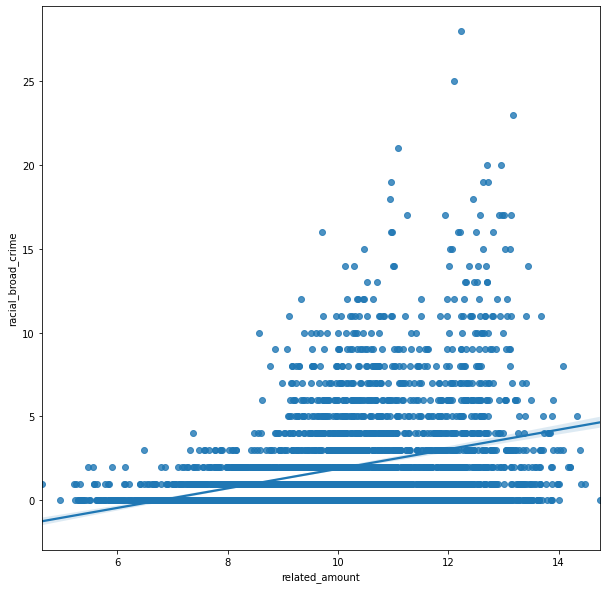

In [48]:
plot_relation(state_df, 'related_amount', 'racial_broad_crime', '', take_log_y=False)